In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tiles3 as tc
import gymnasium as gym
from agents import SarsaLambdaAgent

import time
from IPython.display import clear_output

In [5]:
class TileCoder:

    def __init__(self, iht_size, num_tiles, num_tilings):
        self.iht = tc.IHT(iht_size)
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings

    def get_tiles(self, obs):
        position, velocity = obs
        position *= self.num_tiles / 1.8
        velocity *= self.num_tiles / 0.14
        tiles = tc.tiles(self.iht, self.num_tilings, [position, velocity])
        return np.array(tiles)

In [105]:
def plot(total_reward_list):
    plt.figure(figsize=(4, 3))
    plt.plot(total_reward_list, color='mediumseagreen')
    plt.grid(alpha=0.2)
    plt.title('SARSA(λ) for MountainCar-v0')
    plt.xlabel('episode')
    plt.ylabel('total_reward')
    plt.show()
    clear_output(wait=True)

def render(env, agent):
    img = env.render()
    plt.imshow(img)
    plt.show()
    print(agent.last_tiles)
    clear_output(wait=True)

def cost_to_go(agent, tilecoder, num=25):
    positions = np.linspace(-1.2, 0.6, num)
    velocities = np.linspace(-0.07, 0.07, num)
    X, Y = np.meshgrid(positions, velocities)
    Z = np.zeros([num, num])
    for i, position in enumerate(positions):
        for j, velocity in enumerate(velocities):
            obs = np.array([position, velocity])
            tiles = tilecoder.get_tiles(obs)
            q = -agent.w.max(axis=0)[tiles].sum()
            Z[i, j] = q
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
    surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False, cmap='coolwarm')
    fig.colorbar(surf, shrink=0.5, aspect=15)
    plt.show()
    clear_output(wait=True)

In [112]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
tilecoder = TileCoder(iht_size=1024, num_tiles=4, num_tilings=8)
agent = SarsaLambdaAgent(num_actions=3, tilecoder=tilecoder)
agent.alpha = 0.5 / tilecoder.num_tilings
agent.gamma = 1.0
agent.epsilon = 0.1
agent.lambd = 0.9
total_reward_list = []

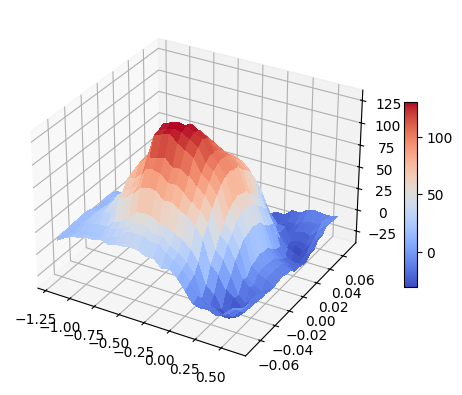

In [113]:
num_episodes = 500
# mode = 'render'
# mode = 'plot'
mode = 'cost'

for episode in range(num_episodes):
    obs, _ = env.reset()
    action = agent.start(obs)
    total_reward = 0
    while True:
        obs, reward, done, over, _ = env.step(action)
        action = agent.step(obs, reward)
        total_reward += reward
        if mode == 'render':
            render(env, agent)
        if done or over:
            agent.end(reward)
            break
    total_reward_list.append(total_reward)
    if mode == 'plot':
        plot(total_reward_list)
    elif mode == 'cost':
        cost_to_go(agent, tilecoder)